In [1]:
import os

device = 'cuda:4'
import torch
import cv2
from PIL import Image
import numpy as np
import random
import tqdm
import json
import matplotlib.pyplot as plt
from data.create_dataset import create_dataset

import sys

sys.path.append('/home/dchenbs/workspace/subobjects-VLM/visual_tokenizer')
from directsam import DirectSAMTokenizer

sys.path.append('/home/dchenbs/workspace/subobjects-VLM/utils')
from visualization import visualize_masks

/home/dchenbs/anaconda3/envs/subobject/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

In [2]:


config = 'configs/visual_tokenizer/directsam_tiny.json'
config = json.load(open(config))
image_resolution = 1024
max_tokens = 36

config['image_resolution'] = image_resolution
config['max_tokens'] = max_tokens
config['device'] = device

model = DirectSAMTokenizer(**config)

DirectSAM initialized on cuda:4


### Load Dataset

In [3]:


dataset_configs = json.load(open('data/dataset_configs.json', 'r'))
print(dataset_configs.keys())

dataset_name = 'EntitySeg'
dataset_config = dataset_configs[dataset_name]
dataset = create_dataset(dataset_config, 'validation', resolution=image_resolution, thickness=3)

dict_keys(['LIP', 'CelebA', 'GTA5', 'DRAM', 'SOBA', 'UDA-Part', 'SeginW', 'CIHP', 'Fashionpedia', 'PartIT', 'PascalPanopticParts', 'SPIN', 'PartImageNet++', 'ADE20k', 'EntitySeg', 'LoveDA', 'COCONut_relabeld_COCO_val', 'COCONut-s', 'COCONut-b', 'COCONut-l', 'COCO2017', 'PACO', 'LVIS', 'directsam_pseudo_label', 'directsam_pseudo_label_merged', 'directsa_plus', 'COIFT', 'DIS5K-DIS-TR', 'DIS5K-DIS-VD', 'DUTS-TE', 'DUTS-TR', 'ecssd', 'fss_all', 'HRSOD', 'MSRA_10K', 'ThinObject5K'])


### Inference and Evaluation

In [4]:


@torch.no_grad()
def get_kernel(radius=5):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device).float()
    return kernel

@torch.no_grad()
def dilate(masks, radius=5):
    kernel = get_kernel(radius)
    masks = masks.unsqueeze(1)
    dilated_masks = torch.nn.functional.conv2d(masks, kernel, padding=radius)
    binary_masks = (dilated_masks > 0.5).float()
    return binary_masks.squeeze(1)


@torch.no_grad()
def erode(masks, radius=5):
    kernel = get_kernel(radius)
    masks = masks.unsqueeze(1)
    dilated_inverted = torch.nn.functional.conv2d(masks, kernel, padding=radius)
    
    eroded_masks = 1 - dilated_inverted
    binary_masks = (eroded_masks > 0.5).float()
    return binary_masks.squeeze(1)


@torch.no_grad()
def masks_to_contour(masks):
    masks = torch.tensor(masks).to(device).float().requires_grad_(False)
    dialated_masks = dilate(masks, radius=3)
    contour = dialated_masks - masks
    return contour


def metric(masks, target):
    # masks: torch cuda tensor, (n_masks, 1024, 1024)

    predicted_contours = masks_to_contour(masks)

    masks = masks.cpu().numpy()
    predicted_contours = predicted_contours.cpu().numpy()

    masks_per_row = 8
    n_cols = masks.shape[0] // masks_per_row + 1

    plt.figure(figsize=(masks_per_row*4, n_cols*4))
    for i in range(masks.shape[0]):
        plt.subplot(n_cols, masks_per_row, i + 1)
        plt.imshow(masks[i], cmap='Blues')
        plt.axis('off')
        # plt.title(batch_masks[0][i].sum())
    plt.show()

    plt.figure(figsize=(masks_per_row*4, n_cols*4))
    for i in range(masks.shape[0]):
        plt.subplot(n_cols, masks_per_row, i + 1)
        plt.imshow(predicted_contours[i], cmap='Blues')
        plt.axis('off')
        # plt.title(batch_masks[0][i].sum())
    plt.show()

    predicted_contour = np.sum(predicted_contours, axis=0) > 0

    plt.figure(figsize=(24, 8))
    plt.subplot(1, 3, 2)
    plt.imshow(target)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_contour)
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]/home/dchenbs/anaconda3/envs/subobject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dchenbs/anaconda3/envs/subobject/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


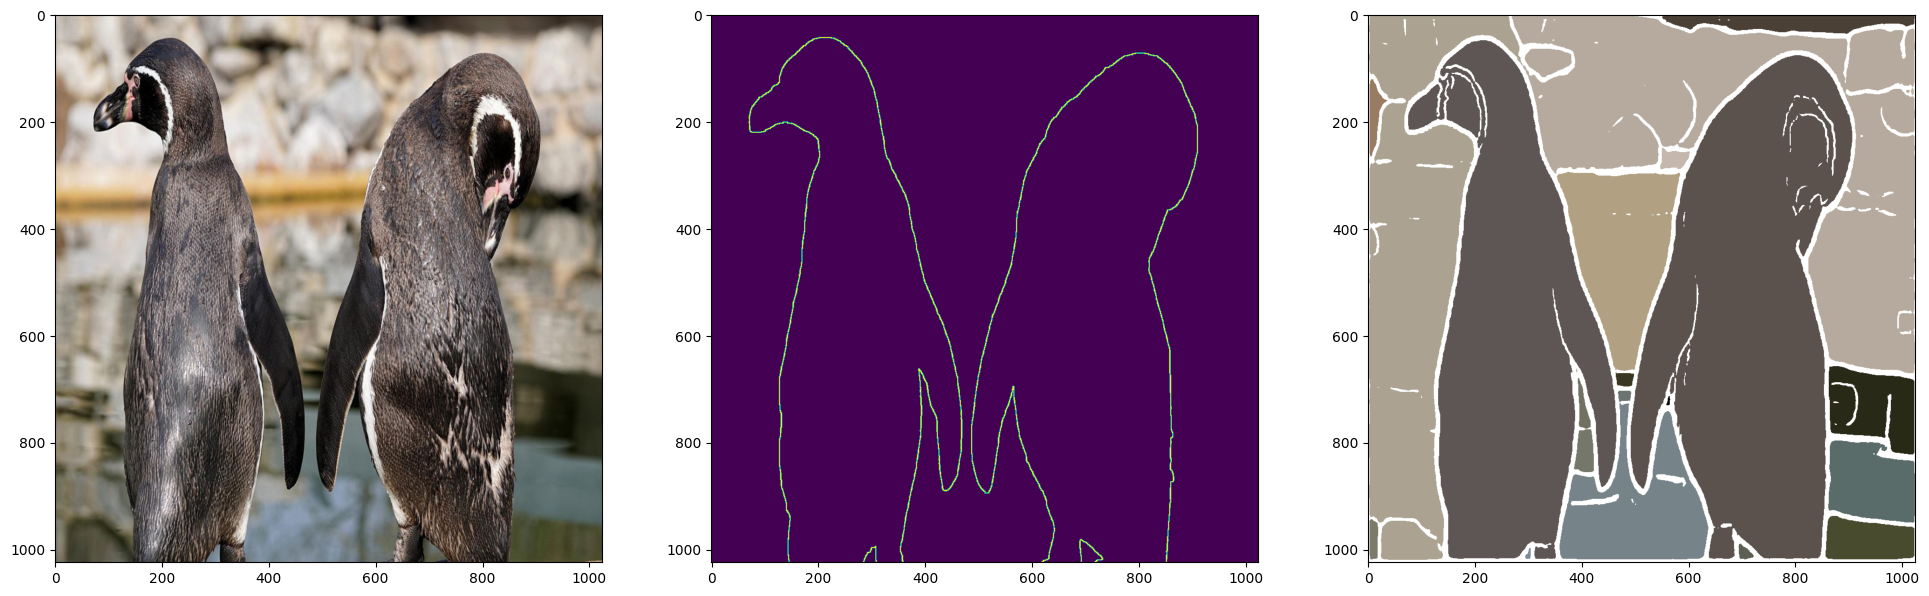

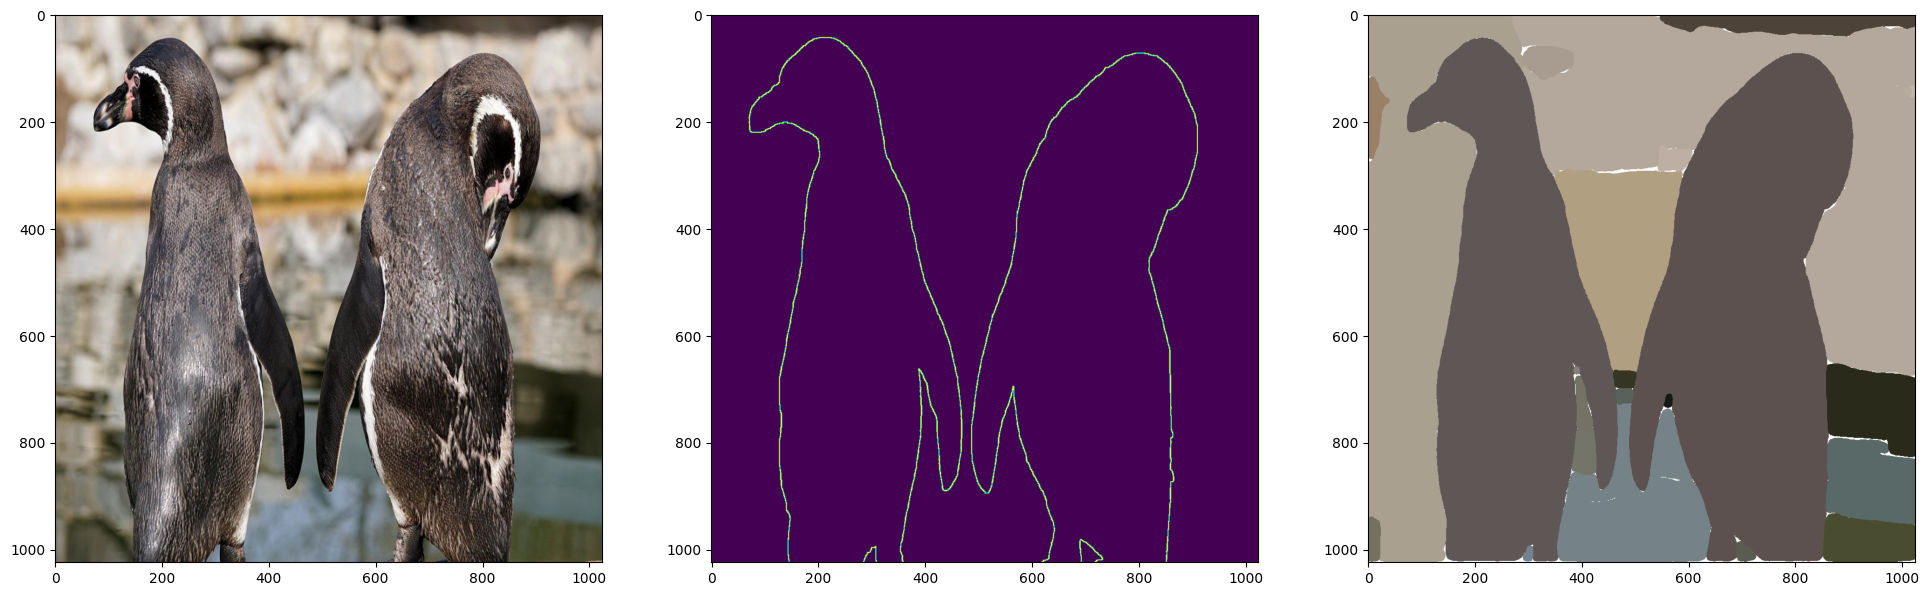

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


In [5]:

for i in tqdm.tqdm(range(1)):
    sample = dataset[random.randint(0, len(dataset)-1)]
    # sample = dataset[i]

    # image_path = dataset.image_paths[i]
    # image = Image.open(image_path)
    # print(image_path, image.size)

    if type(sample) == dict:
        image = sample['image']
        target = sample['label']
    else:
        image, target = sample

    masks = model([image])[0]

    plt.figure(figsize=(24, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(target)
    plt.subplot(1, 3, 3)
    plt.imshow(visualize_masks(image, masks.cpu().numpy()))
    plt.show()

    masks = masks.to(device).float()
    masks = dilate(masks, radius=image_resolution//200)
    # masks = erode(masks, radius=image_resolution//200)
    
    plt.figure(figsize=(24, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(target)
    plt.subplot(1, 3, 3)
    plt.imshow(visualize_masks(image, masks.cpu().numpy()))
    plt.show()

    # metric(masks, target)


